# TP : Maximum entropy principle and Langevin algorithm
Author: [Valentin De Bortoli](https://vdeborto.github.io/)

Edits by [Bruno Galerne](https://www.idpoisson.fr/galerne/)

   ## Summary
   1. [The Unadjusted Langevin Algorithm](#ULA)  
       1.1 [A first example](#first_ex)   
       1.2 [Some convergence diagnostics](#diagnostics)  
   2. [Stochastic Optimization with Unadjusted Langevin](#SOUL)  
       2.1 [The Simplest Neural Network](#simplest_nn)  
       2.2 [An inverse problem](#inverse)
   3. [Texture synthesis using SOUL](#SOULTexture)

We will need the following packages.

In [10]:
import numpy as np
from ipywidgets import *
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from sklearn import datasets
from tqdm import tqdm
from draw_functions import *

## The Unadjusted Langevin Algorithm
<a id="ULA"></a>

First, we tackle the following problem. Given $U : \ \mathbb{R}^d \to \mathbb{R}$ with $d \in \mathbb{N}$, how to sample from $\pi$ where for any $x \in \mathbb{R}^d$, $(\mathrm{d} \pi / \mathrm{d} \mathrm{Leb})(x) = \exp[-U(x)]$ ?

If we could sample from continuous-time dynamics then considering the following Stochastic Differential Equation (SDE)
\begin{equation}\mathrm{d} \mathbf{X}_t = - \nabla U(\mathbf{X}_t) \mathrm{d}_t + \sqrt{2} \mathrm{d} \mathbf{B}_t \; , \end{equation}
we obtain that, under suitable conditions on the potential $U$, $(\mathcal{L}(\mathbf{X}_t))_{t \geq 0}$ converges towards $\pi$, where for any $t \geq 0$, $\mathcal{L}(\mathbf{X}_t)$ is the law of $\mathbf{X}_t$. However, most of the time, it is not possible to sample from this continuous-time dynamics and we must define suitable discretizations. In this sense, the Unadjusted Langevin Algorithm (ULA) is the Euler-Maruyama discretization of the previous dynamics and is given by the following recursion: let $X_0 \in \mathbb{R}^d$ and for any $n \in \mathbb{N}$, 
\begin{equation}
X_{n+1} = X_n - \gamma \nabla U(X_n) + \sqrt{2 \gamma} Z_{n+1} \; ,
\end{equation}
where $\gamma > 0$, $(Z_n)_{n \in \mathbb{N}}$ is a collection of $d$-dimensional Gaussian random variables with zero mean and identity covariance matrix. Under mild conditions on the potential $U$ (for instance Lipschitz gradient and convex at infinity), we get that this algorithm converges and there exists $\pi_{\gamma}$ such that $(\mathcal{L}(X_n))_{n \in \mathbb{N}}$ converges toward $\pi_{\gamma}$. $\pi_{\gamma}$ is no longer equal to $\pi$ (this is why the numerical scheme is called "unadjusted"), however the bias between the two probability measures is of order $\gamma$.

### A first example
<a id="first_ex"></a>

First, we consider the problem of sampling from a Gaussian mixture model (GMM). 
Of course, ULA algorithm is sub-optimal to achieve this task but it will allow us 
to build some insights about the behavior of such Markov chains.
We start by defining the Gaussian mixture models. For this we introduce two simple classes for Gaussian and GMM distributions in $\mathbb{R}^2$. 

In [11]:
class Gaussian_2D:

    def __init__(self, mu, cov):
        self.mu = mu
        self.cov = cov
        self.prec = np.linalg.inv(cov)

    def fun(self, x):
        mu = self.mu
        cov = self.cov
        prec = self.prec

        x_shift = x - mu
        val = np.linalg.det(2 * np.pi * cov) ** (-1 / 2)
        val = val * np.exp(- np.dot(x_shift, np.dot(prec, x_shift)) / 2)
        return val

    def grad(self, x):
        mu = self.mu
        prec = self.prec
        x_shift = x - mu
        val = - self.fun(x) * np.dot(prec, x_shift)
        return val


class Mixture_Gaussian_2D:

    def __init__(self, mu_list, cov_list, w_list):
        self.mu_list = mu_list
        self.cov_list = cov_list
        self.w_list = w_list
        self.prec_list = [np.linalg.inv(cov) for cov in cov_list]
        self.gaussian_list = [Gaussian_2D(*m) for m in zip(mu_list, cov_list)]

    def fun(self, x):
        val = 0
        for w, gauss in zip(self.w_list, self.gaussian_list):
            val += w * gauss.fun(x)
        return val

    def log_likelihood_fun(self, x):
        return np.log(self.fun(x))

    def log_likelihood_grad(self, x):
        val = 0
        for w, gauss in zip(self.w_list, self.gaussian_list):
            val += w * gauss.grad(x)
        val = val / self.fun(x)
        return val

    def sample(self, Ndata):
        mu = self.mu_list
        cov = self.cov_list
        w = self.w_list

        x = np.zeros((Ndata, 2))
        z = np.random.randn(Ndata, 2)
        ncomp = len(w)
        idx_arr = np.random.choice(ncomp, Ndata, p=w)
        k = 0
        for idx in idx_arr:
            x[k, :] = mu[idx] + np.dot(sqrtm(cov[idx]), z[k, :])
            k += 1
        return x

Now let us define and visualize some Gaussian mixture models.

**Remark:** since the Gaussian mixture, is computed each time it may take some time to plot the density when you change the parameters.

In [12]:
def update(dilatation=(0,3,0.1), sigma=(0.1,1,0.1)):
    dil = dilatation
    sigma_sq = sigma ** 2
    mu_list = [np.array([-dil, -dil]), np.array([dil, -dil]),
           np.array([-dil, dil]), np.array([dil, dil])]
    cov_list = []
    cov_list.append(sigma_sq * np.array([[2, 0], [0, 1]]))
    cov_list.append(sigma_sq * np.array([[1, 0], [0, 2]]))
    cov_list.append(sigma_sq * np.array([[1, 0], [0, 1]]))
    cov_list.append(sigma_sq * np.array([[1, 0], [0, 1]]))
    w1_list = [1 / 8, 1 / 2, 1 / 8, 1 / 4]
    w2_list = [1 / 4, 1 / 4, 1 / 4, 1 / 4]

    model1 = Mixture_Gaussian_2D(mu_list, cov_list, w1_list)
    model2 = Mixture_Gaussian_2D(mu_list, cov_list, w2_list)

    fig, ax = plt.subplots(1, 2)
    _ =draw_density(model1, ax[0])
    _ = draw_density(model2, ax[1])
    fig.canvas.draw_idle()

interact(update);

interactive(children=(FloatSlider(value=1.0, description='dilatation', max=3.0), FloatSlider(value=0.5, descri…

Now let us code the Unadjusted Langevin Algorithm:

**Question:** Fill in the above function to simulate the Unajusted Langevin Markov Chain.

In [13]:
def langevin(model, x0, gamma, N):
    x_list = [x0]
    x = np.copy(x0)
    
    #TODO: Compute grad array
    
    for k in range(N):
        
        #TODO: Langevin iteration: x += ????
        
        x_list.append(np.copy(x))
    return x, x_list    

Fix some parameters and give it a try.

In [9]:
dil = 1.
sigma_sq = 0.2
mu_list = [np.array([-dil, -dil]), np.array([dil, -dil]),
           np.array([-dil, dil]), np.array([dil, dil])]
cov_list = []
cov_list.append(sigma_sq * np.array([[2, 0], [0, 1]]))
cov_list.append(sigma_sq * np.array([[1, 0], [0, 2]]))
cov_list.append(sigma_sq * np.array([[1, 0], [0, 1]]))
cov_list.append(sigma_sq * np.array([[1, 0], [0, 1]]))
w_list = [1 / 4, 1 / 4, 1 / 4, 1 / 4]#[1 / 8, 1 / 2, 1 / 8, 1 / 4]


model = Mixture_Gaussian_2D(mu_list, cov_list, w_list)

x0 = np.random.randn(2)
gamma = 10 ** -2
N = 2*10 ** 4
x, x_list = langevin(model, x0, gamma, N)

NameError: name 'langevin' is not defined

Let us visualize the obtained samples. 

**Question:** What do you observe when varying ```Tmax```?

In [14]:
def update(Tmax=(10**3, N, 10 **3)):
    draw_model(model, x_list, Tmax)
    
interact(update);    

interactive(children=(IntSlider(value=10000, description='Tmax', max=20000, min=1000, step=1000), Output()), _…

### Some convergence diagnostics
<a id="diagnostics"></a>

The convergence of a Markov chain can be difficut to establish.
In this section, we propose two criteria to run diagnostics on the chain:
- the autocorrelation of the chain,
- the evaluation of integral.

The autocorrelation is a proxy to evaluate the dependence between two samples with a time-shift.
If the autocorrelation remains close to $1$ then the chain is not mixing enough and we can suspect that convergence has not occured. 

In [15]:
time_lags = np.arange(0, 10 ** 3, 2 * 10**1)

def autocorrelation(x_list, time_lags, comp=0, burnin=0):
    x_list = x_list[burnin:]
    x_arr = np.array(x_list)
    mean = np.mean(x_arr, 0)
    auto_list = []
    for lag in time_lags:
        x_list_shift = x_list[lag:]
        x_list_crop = x_list[:len(x_list_shift)]
        x1 = np.array(x_list_shift) - mean
        x2 = np.array(x_list_crop) - mean
        x1 = x1[:, comp]
        x2 = x2[:, comp]
        normalization = np.sqrt(np.dot(x1, x1) * np.dot(x2, x2))
        auto = np.dot(x1, x2) / normalization
        auto = np.abs(auto)
        auto_list.append(auto)
    return auto_list

def update(gamma=(0.001, 0.041, 0.02)):
    x, x_list = langevin(model, x0, gamma, N)
    auto_list = autocorrelation(x_list, time_lags, burnin=10**3)
    plt.plot(time_lags, auto_list, 'x')
    title = 'gamma ' + str(gamma)
    plt.title(title)
    plt.show()
    
interact(update);    

interactive(children=(FloatSlider(value=0.021, description='gamma', max=0.041, min=0.001, step=0.02), Output()…

The autocorrelation measurement allows us to check that the long-range samples of the Markov chains are not correlated. However, it does not inform us about the convergence of the Markov chain towards its equilibrium.
To do so, one may compute approximated integrals using the Markov chain.
For instance, in our case we can exactly compute the mean of the mixture of Gaussians.

In [ ]:
# True mean:
w_arr = np.array(w_list)
mu_arr = np.array(mu_list)
mu = np.sum(w_arr.reshape(w_arr.shape + (1,)) * mu_arr, 0)

# Integration over Langevin Markov chain:
x0 = np.random.randn(2)
gamma = 10 ** -2
N = 2*10 ** 4
x, x_list = langevin(model, x0, gamma, N)
x_arr = np.array(x_list)
mu_est = np.mean(x_arr, 0)
s1 = 'True mean:  ' + str(mu)
s2 = 'Estimated mean: ' + str(mu_est)
print(s1 + '\n' + s2)

## Maximum entropy estimation
<a id="SOUL"></a>

In the previous section, we supposed that we knew the density of the model we tried to produce samples from this model. Now, we consider the reverse problem. We assume that we have access to a fix number of samples of the model (this number can be equal to one! See the texture synthesis application) and we try to find a good model which fits the data.

Therefore, our task can be divided into two parts:
- finding suitable models to describe the data,
- given a model and the data, provide an algorithm to find the "best" model according to the data.

First, we describe a simple (one-layer) neural network which can describes toy datasets. 
Then, we turn to the implementation of the Stochastic Optimization with Unadjusted Langevin (SOUL) algorithm.

### The Simplest Neural Network
<a id="simplest_nn"></a>

Suppose we are given a dataset $\mathcal{X} \in \mathbb{R}^{N \times d}$ where $N$ is the number of samples and $d$ their dimension. Let $a \in \mathbb{R}^d$ and $b \in \mathbb{R}$. We consider the following approximation
\begin{equation}
\mathbb{E}[f_{a,b}(X)] \simeq N^{-1} \sum_{j=1}^N f_{a,b}(\mathcal{X}_j) \; ,
\end{equation}
where $f_{a,b}: \ \mathbb{R}^d \to [0, +\infty)$ is given for any $x \in \mathbb{R}^d$ by 
\begin{equation}
f_{a,b}(x) = (\langle a, x \rangle + b)_+ \; .
\end{equation}
We assume that we have access to $p$ functions $(f_{a_i,b_i})_{i \in \{1, \dots, p\}}$.
Our goal is to find the model (distribution over $\mathbb{R}^d$, $\pi$) which has maximum entropy given the following constraints. For any $i \in \{1, \dots, p\}$, we have
\begin{equation}
\int_{\mathbb{R}^d} f_{a_i, b_i}(x) \mathrm{d} \pi(x) = N^{-1} \sum_{j=1}^N f_{a_i,b_i}(\mathcal{X}_j) \; .
\end{equation}
For simplicity, in this lab-session $(a_i)_{i \in \{1, \dots, p\}}$ are (fixed) realizations of a $d$-dimensional Gaussian random variable with zero mean and identity covariance. Similarly $(b_i)_{i \in \{1, \dots, p\}}$ are (fixed) realizations of a univariate Gaussian random variable with zero mean and identity covariance. The two random variables are supposed to be independent. Let us first describe the features we consider.

In [16]:
class feature():
    def __init__(self, N, data, activation='relu'):
        d = data.shape[-1]
        feature.activation = activation
        feature.d = d
        feature.N = N
        alpha, beta = self.random(N)
        feature.alpha = alpha
        feature.beta = beta

        target = self.montecarlo(data)
        feature.target = target

    def random(self, N):
        d = self.d
        alpha = np.random.randn(N, 1, d)
        beta = np.random.randn(N, 1)
        return alpha, beta

    def eval(self, x):
        alpha = self.alpha
        beta = self.beta

        out = np.sum(alpha * x, -1) + beta
        if self.activation == 'relu':
            out = out * (out > 0)
        elif self.activation == 'abs':
            out = np.abs(out)
        return out

    def grad(self, x):
        alpha = self.alpha
        beta = self.beta

        out = np.sum(alpha * x, -1) + beta
        if self.activation == 'relu':
            out = out > 0
        elif self.activation == 'abs':
            out = np.sign(out)
        out = out.reshape(out.shape + (1,))
        out = out * alpha
        return out

    def montecarlo(self, data):
        out = self.eval(data)
        out = np.mean(out, 1)
        out = out.reshape(out.shape + (1,))
        return out

**Questions:**
1. What is computed in feature.target?
2. What is computed by the feature.grad function?

We recall the maximum entropy problem. Given a reference probability measure $\mu$ and a function $F: \ \mathbb{R}^d \to \mathbb{R}^p$ we want to find (if it exists) a probability measure $\pi$ which solves the following problem
\begin{equation}
\min_{\pi \in \mathcal{P}_{\alpha, F}} \mathrm{KL}(\pi | \mu) \; ,
\end{equation}
where $\mathcal{P}_{\alpha, F} = \{ \pi \in \mathcal{P}_{\alpha}, \ \int_{\mathbb{R}^d} F(x) \mathrm{d}\pi(x) = 0 \}$, $\mathcal{P}_{\alpha} = \{ \pi \in \mathcal{M}(\mathbb{R}^d), \ \int_{\mathbb{R}^{d}} \| x \|^{\alpha} \mathrm{d} x < +\infty \}$ and $\mathcal{M}(\mathbb{R}^d)$ is the set of probability measures over $\mathbb{R}^d$.
In addition, $\sup_{x \in \mathbb{R}^d} \left\lbrace \| F(x) \| (1+ \| x \|)^{-\alpha} \right\rbrace < +\infty$. Under suitable conditions on the measure $\mu$ and the function $F$ we obtain that the solution of this minimization problem exists, is unique and is given for any $x \in \mathbb{R}^d$ by 
\begin{equation}
(\mathrm{d} \pi_{\theta^{\star}} / \mathrm{d} \mu)(x) = \exp[- \langle \theta^{\star}, F(x) \rangle] \; ,
\end{equation}
where $\theta^{\star}$ is the solution of the convex problem
\begin{equation}
\min_{\theta \in \Theta} L(\theta) \; ,
\end{equation}
where $\Theta = \{ \theta \in \mathbb{R}^p, \ \int_{\mathbb{R}^{d}} \exp[- \langle \theta, F(x) \rangle ] \mathrm{d} \mu(x) < +\infty\}$ and $L(\theta)$ is the log-partition function given for any $\theta \in \Theta$ by 
\begin{equation}
L(\theta) = \int_{\mathbb{R}^d} \exp[-\langle \theta, F(x) \rangle] \mathrm{d} \mu (x) \; .
\end{equation}

In our running example, we will consider $F = (f_{a_i, b_i} - c_i)_{i \in \{1, \dots, p\}}$ where the $c_i$ are the target statistics
\begin{equation}
c_i = \frac{1}{N}\sum_{j=1}^N f_{a_i,b_i}(\mathcal{X}_j) \; .
\end{equation}
We will take the reference measure to be a Gaussian distribution with zero mean and diagonal covariance with entries given by $\sigma^2$ with $\sigma$ large.

### Stochastic Optimization with Unadjusted Langevin
<a id="inverse"></a>

We now assume that $\mu$ admits a Radon-Nikodym derivative with respect to the Lebesgue measure, and denote $r: \ \mathbb{R}^d \to \mathbb{R}$ such that for any $x \in \mathbb{R}^d$, 
\begin{equation}
(\mathrm{d} \mu / \mathrm{d} \mathrm{Leb})(x) = \exp[-r(x)] \; .
\end{equation}
In our running example, we have $r(x) = \| x \|^2/ (2 \sigma^2)$.
In this case, the Stochastic Optimization with Unadjusted Langevin (SOUL) algorithm aims at finding the optimal parameters $\theta^{\star}$ by performing a stochastic gradient on $L$, whose gradient is approximated by a Monte Carlo average.

In [17]:
def soul(params):
    d = params['d']
    delta = params['delta']
    gamma = params['gamma']
    m = params['m']
    Nit = params['Nit']
    stride = params['stride']
    target = params['target']
    fun = params['fun']
    grad = params['grad']
    init_theta = params['init_theta']
    init_x = params['init_x']
    sigma = params['sigma']

    x_list = []
    theta_list = []

    x = init_x
    theta = np.reshape(init_theta, (init_theta.shape + (1,)))
    target = np.reshape(target, (target.shape + (1,)))

    for n in tqdm(range(Nit)):
        if n % stride == 0:
            x_list.append(x)
            theta_list.append(theta)
        feat_avg = 0
        for k in range(m):
            noise = np.random.randn(d)
            update = np.sum(np.sum(theta * grad(x), 0), 0)
            update = update - sigma ** (-2) * x
            x = x - gamma * update + np.sqrt(2 * gamma) * noise
            feat_avg = (k * feat_avg + fun(x)) / (k + 1)

        feat_avg = np.reshape(feat_avg, (feat_avg.shape + (1,)))
        theta = theta + delta * (feat_avg - target)

    x_arr = np.array(x_list)
    theta_arr = np.array(theta_list)
    theta_arr = theta_arr.squeeze()
    return x_arr, theta_arr

The following function selects a dataset which will be used to perform the estimation.

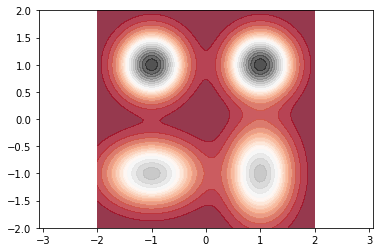

In [27]:
# 2D GMM density for for sampling data
dil = 1
sigma_sq = 0.15
mu_list = [np.array([-dil, -dil]), np.array([dil, -dil]),
           np.array([-dil, dil]), np.array([dil, dil])]
cov_list = []
cov_list.append(sigma_sq * np.array([[2, 0], [0, 1]]))
cov_list.append(sigma_sq * np.array([[1, 0], [0, 2]]))
cov_list.append(sigma_sq * np.array([[1, 0], [0, 1]]))
cov_list.append(sigma_sq * np.array([[1, 0], [0, 1]]))
w_list = [1 / 4, 1 / 4, 1 / 4, 1 / 4] #[1 / 8, 1 / 2, 1 / 8, 1 / 4]
gmm2d = Mixture_Gaussian_2D(mu_list, cov_list, w_list)

# View 2D GMM density
fig, ax = plt.subplots(1,1)
draw_density(gmm2d, ax)

Ns = 2*10 ** 5
p = 10 ** 2

# 
f = feature(p, gmm2d.sample(Ns), activation = 'relu')

params = {'d': 2,
          'sigma': 10,
          'delta': 10 ** -2,
          'gamma': 10 ** -2,
          'm': 10 ** 2,
          'Nit': 2*10 ** 4,
          'stride': 10 ** 1,
          'target': f.target,
          'fun': f.eval,
          'grad': f.grad,
          'init_x': np.array([0, 0]),
          'init_theta': f.eval(np.array([0, 0])) * 0}

We now apply the SOUL algorithm.

In [28]:
x_arr, theta_arr = soul(params)

100%|██████████| 20000/20000 [01:27<00:00, 229.68it/s]


First, let us observe the output samples.

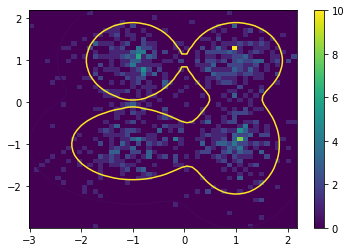

In [19]:
draw_estimated_density(x_arr, gmm2d)

Now, let us take a look at the estimated parameters.

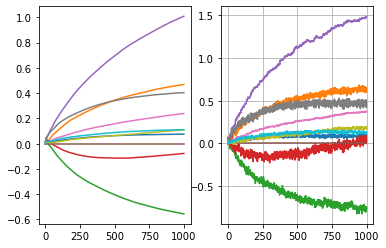

In [20]:
draw_theta(theta_arr)

Obvsiouly, we only have an approximation of the mixture of Gaussians.
It is interesting to visualize the density we obtain. Notice that the contours of the density are segments which is coherent with our features which have different behavior depending on the half-space.

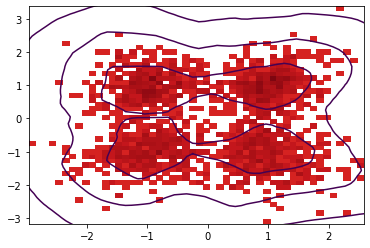

In [38]:
draw_learn_density(f, x_arr, theta_arr)    

**Questions:**
Adapt the function draw_learn_density (code reproduced below) into draw_learn_density_select and check that the mean of the 20 last theta values provide an exponential model that is better adpated than the mean of the 20 theta values starting at BURNIN.

In [36]:
def draw_learn_density_select(model, x_arr, theta_arr):
    BURNIN = 10 ** 2
    NBINS = 50
    vmin = 10 ** -5
    vmax = 1
    x1 = x_arr[BURNIN:, 0].view()
    x2 = x_arr[BURNIN:, 1].view()
    plt.hist2d(x1, x2, bins=NBINS, cmap=plt.cm.Reds,
               density=True, norm=colors.LogNorm(vmin, vmax))

    RANGE = 5
    axis = np.linspace(-RANGE, RANGE, 10 ** 2)
    X, Y = np.meshgrid(axis, axis)
    xy = np.vstack([Y.ravel(), X.ravel()]).T

    theta_arr_m = theta_arr[BURNIN:, :]
    theta_arr_m = np.mean(theta_arr_m, 0)
    out = density_model(model, theta_arr_m, xy)
    out = out.reshape(X.shape)
    contour_disc = np.flip(np.exp(-np.linspace(0, 5, 10 ** 1) ** 2))
    plt.contour(X, Y, out, contour_disc)

    plt.show()

(20, 100)


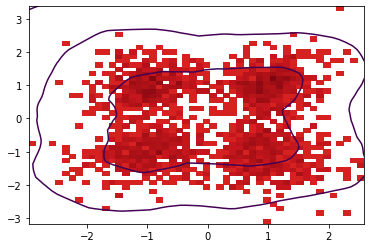

In [37]:
draw_learn_density_select(f, x_arr, theta_arr)

## Texture synthesis using SOUL
<a id="#SOULTexture"></a>

You can try the SOUL algorithm for texture synthesis using the following links:

[google colab](https://colab.research.google.com/drive/18TnAo5VCnnSv6zY4_t_5mdPwtpgjp0Xx#scrollTo=7e6XtairZ4TB)

from source release:

[gitlab source code: macrocanonical synthesis](https://gitlab.com/vdeborto/macrocanonical-synthesis)




In [39]:






# sol Langevin:
# grad = model.log_likelihood_grad
# x += gamma * grad(x) + np.sqrt(2 * gamma) * np.random.randn(2)



